## Detección de Cáncer de Piel con Redes Neuronales Convolucionales

Trabajo realizado por Francisco Devaux para la materia Inteligencia Artificial II de la Licenciatura en Ciencias de la Computación de la Universidad Nacional de Cuyo.


### Descripción del Problema

El cáncer de piel es uno de los tipos de cáncer más comunes en todo el mundo. Entre las formas más graves de esta enfermedad se encuentra el melanoma, que puede ser fatal si no se detecta a tiempo. Sin embargo, una detección temprana puede aumentar significativamente las probabilidades de tratamiento exitoso y recuperación.

El objetivo de este proyecto es construir un modelo de aprendizaje profundo que clasifique imágenes de lunares como benignos o malignos. Utilizando un conjunto de datos de imágenes etiquetadas, se entrena un modelo capaz de diferenciar entre ambas clases, basado en características visuales extraídas automáticamente.

Dicho dataset fue obtenido de la plataforma Kaggle. Se puede acceder al mismo a través del siguiente enlace: [Melanoma Skin Cancer Dataset of 10000 Images](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images)

Esta solución tiene el potencial de servir como herramienta de apoyo para dermatólogos, ayudándolos a priorizar casos sospechosos y a mejorar la precisión en los diagnósticos.

En este notebook, se describen las siguientes etapas:
<br><br>

1. **Preparación y Visualización de Datos**: Carga y preprocesamiento de las imágenes. Gráficos de distribución de las clases.
<br><br>

2. **Construcción del Modelo**: Definición, entrenamiento y optimización de un modelo basado en redes neuronales convolucionales (CNNs).
<br><br>

3. **Evaluación del Modelo**: Validación del rendimiento sobre el conjunto de testeo, mediante métricas como _accuracy_, _precision_, _recall_,  _f1-score_ y la generación de una matriz de confusión.
<br><br>

4. **Conclusión**: Resumen de los resultados.

#### Importación de librerías 

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from keras import Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.image as mpimg

### 1. Preparación y Visualización de Datos

A continuación se cargan los directorios de las imágenes de entrenamiento y testeo, y el tamaño de las imágenes a utilizar.

In [3]:
train_dir = 'melanoma_cancer_dataset/train'
test_dir = 'melanoma_cancer_dataset/test'
IMG_SIZE = (150, 150)

En los siguientes gráficos se observa la distribución entre las clases benignas y malignas.

Train Class Distribution:


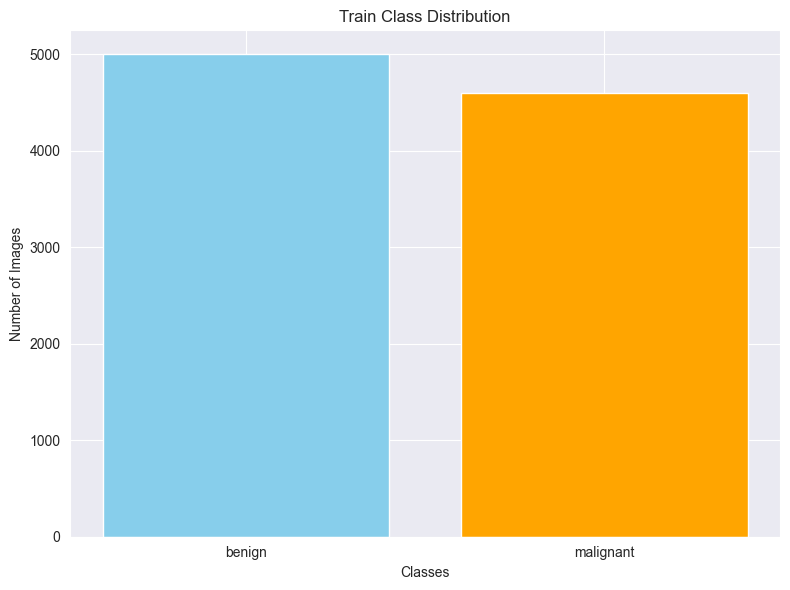

Test Class Distribution:


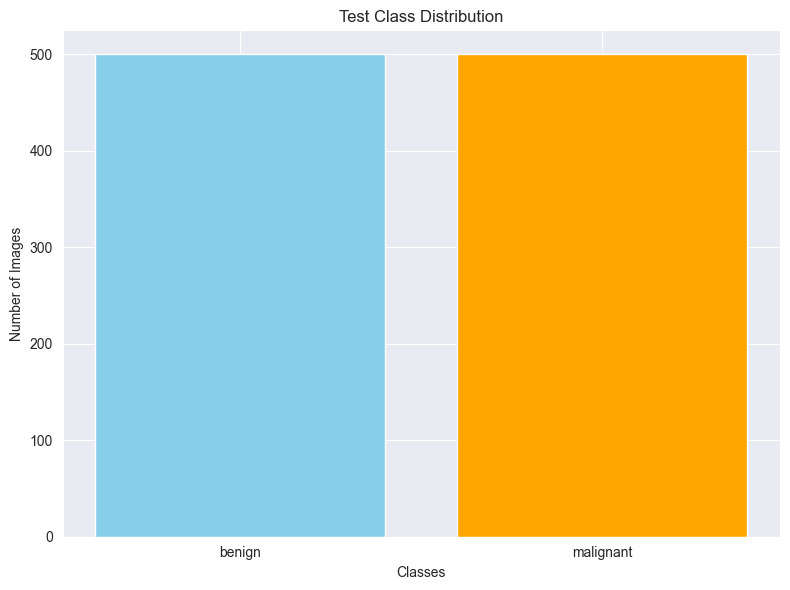

In [8]:
def show_class_distribution(directory, title="Class Distribution"):
    class_counts = {}
    
    # Contar imágenes en cada subcarpeta
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    
    # Graficar la distribución
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color=['#87ceeb','#ffa500'])
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()
    
print("Train Class Distribution:")
show_class_distribution(train_dir, title="Train Class Distribution")

print("Test Class Distribution:")
show_class_distribution(test_dir, title="Test Class Distribution")


Como se puede observar, las clases se encuentran balanceadas, habiendo una mínima diferencia en el conjunto de entrenamiento. En el conjunto de testeo, el balanceo es perfecto.

A continuación se mostrarán algunas imágenes de lunares benignos y malignos pertenecientes al dataset. 

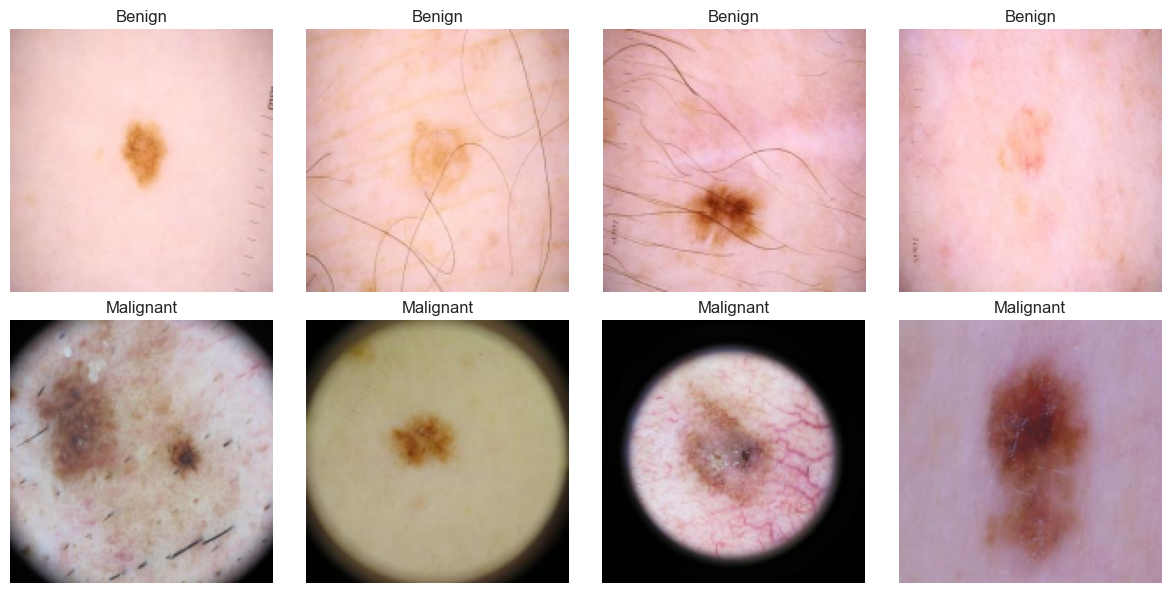

In [4]:
def show_examples(directory, num_examples=4):
    fig, axes = plt.subplots(2, num_examples, figsize=(12, 6))
    axes = axes.flatten()
    categories = ['benign', 'malignant']
    
    for idx, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images = os.listdir(category_path)
        selected_images = images[:num_examples]  # Seleccionar las primeras n imágenes

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
            img = cv2.resize(img, IMG_SIZE)
            
            ax = axes[idx * num_examples + i]
            ax.imshow(img)
            ax.set_title(category.capitalize())
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_examples(train_dir)

### 2. Construcción del Modelo

Se define una función para cargar las imágenes de un directorio y sus respectivas etiquetas.
Además, se normalizan los valores de los pixeles de las imágenes.

In [5]:
def load_images_from_directory(directory):
    images = []
    labels = []
    for label, subdir in enumerate(['benign', 'malignant']):
        subdir_path = os.path.join(directory, subdir)
        for filename in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Cargar datos y normalizar
X, y = load_images_from_directory(train_dir)
X = X / 255.0

Se divide el conjunto de entrenamiento en entrenamiento y validación.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=22)

Se hará una búsqueda de hiperparámetros para encontrar una arquitectura de red neuronal convolucional que se ajuste a los datos. Para ello, se utilizará la librería _keras-tuner_. 
Se definirá una función que construya el modelo de red neuronal convolucional, varíando los valores de:
- El número de filtros de las capas convolucionales
- El tamaño del kernel
- Las unidades de las capas densas
- La tasa de dropout
- La tasa de aprendizaje

Se harán 20 iteraciones para encontrar la mejor arquitectura.

Se utilizará _early_stop_ para detener el entrenamiento si no se observa mejora en la función de pérdida, ahorrando así tiempo de cómputo.


In [7]:
def build_model(hp):
    model = tf.keras.Sequential([
        Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5]),
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=64),
            activation='relu'
        ),
        tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear un tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='melanoma_tuning'
)

# Crear el callback de EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

Reloading Tuner from my_dir\melanoma_tuning\tuner0.json


Además se creó la clase SaveResultsCallback que permitirá guardar los resultados de cada iteración en un archivo csv, junto con gráficos de como varían la función de pérdida y las métricas a medida que aumentan el número de epochs.

In [8]:
class SaveResultsCallback(tf.keras.callbacks.Callback):
    def __init__(self, base_path='results', folder_name=None):
        super().__init__()
        self.base_path = base_path
        self.folder_name = folder_name

    def on_train_end(self, logs=None):
        # Si se proporciona un nombre, usarlo; de lo contrario, buscar un nombre único
        if self.folder_name:
            trial_folder = os.path.join(self.base_path, self.folder_name)
        else:
            trial_folder = get_unique_trial_folder(self.base_path)

        # Crear la carpeta de resultados
        os.makedirs(trial_folder, exist_ok=True)

        # Guardar resultados en CSV
        history_df = pd.DataFrame(self.model.history.history)
        csv_filename = os.path.join(trial_folder, "trial_results.csv")
        history_df.to_csv(csv_filename, index=False)

        # Graficar y guardar Accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(history_df['accuracy'], label='Train Accuracy')
        plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        accuracy_path = os.path.join(trial_folder, "accuracy.png")
        plt.savefig(accuracy_path)
        plt.close()

        # Graficar y guardar Loss
        plt.figure(figsize=(10, 5))
        plt.plot(history_df['loss'], label='Train Loss')
        plt.plot(history_df['val_loss'], label='Validation Loss')
        plt.title('Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        loss_path = os.path.join(trial_folder, "loss.png")
        plt.savefig(loss_path)
        plt.close()

        

        print(f"Results and metadata saved to {trial_folder}")

def get_unique_trial_folder(base_path):
    counter = 1
    while os.path.exists(f"{base_path}/trial_{counter}"):
        counter += 1
    return f"{base_path}/trial_{counter}"

Se entrena el modelo con los datos de entrenamiento y validación, con un número máximo de epochs de 50. Al final se obtienen los mejores hiperparámetros encontrados. 

In [9]:
# Crear directorio para guardar resultados
os.makedirs('results', exist_ok=True)

# Realizar la búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, SaveResultsCallback()]
)

Trial 20 Complete [00h 16m 53s]
val_accuracy: 0.9167100191116333

Best val_accuracy So Far: 0.9182717204093933
Total elapsed time: 18h 45m 13s


In [10]:
# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Mejor número de filtros: {best_hps.get('filters')}
Mejor tamaño del kernel: {best_hps.get('kernel_size')}
Mejor número de unidades: {best_hps.get('units')}
Mejor tasa de aprendizaje: {best_hps.get('learning_rate')}
Mejor dropout: {best_hps.get('dropout')}
""")

best_trial_id = None
for trial_id, trial in tuner.oracle.trials.items():
    if trial.hyperparameters.values == best_hps.values:
        best_trial_id = trial_id
        break

print(f"El mejor trial fue: {int(best_trial_id) + 1}")


Mejor número de filtros: 128
Mejor tamaño del kernel: 3
Mejor número de unidades: 128
Mejor tasa de aprendizaje: 0.0001
Mejor dropout: 0.30000000000000004

El mejor trial fue: 4


Una vez obtenidos los mejores hiperparámetros, se procede a obtener el modelo correspondiente, guardarlo como archivo y mostrar sus gráficos correspondientes.

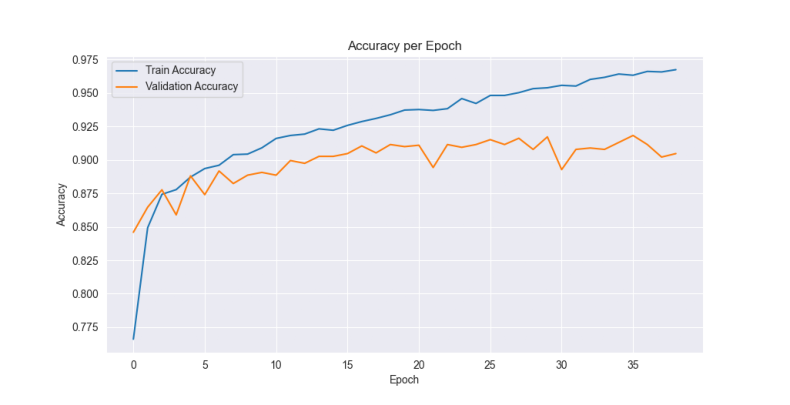

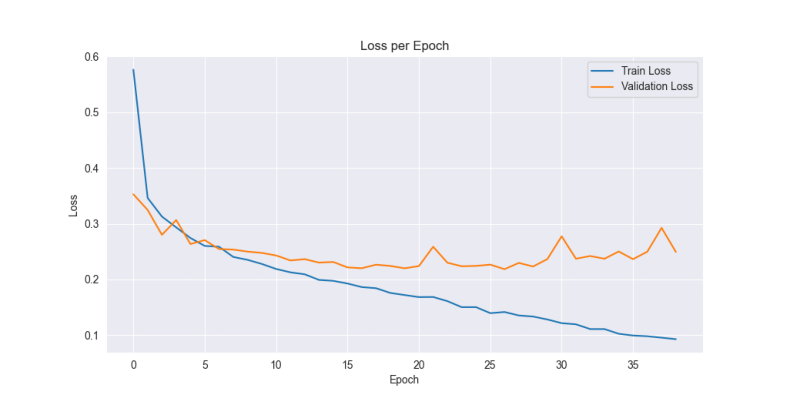

C:\Users\User\Desktop\Codigos\IA2ProyectoFinal\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
def display_images(image_paths):
    for image_path in image_paths:
        if image_path and os.path.exists(image_path):
            img = mpimg.imread(image_path)
            plt.figure(figsize=(10, 5))
            plt.imshow(img)
            plt.axis('off')  # Ocultar los ejes
            plt.show()
        else:
            print(f"Image not found: {image_path}")

# Mostrar las imágenes
display_images([f'results/trial_{int(best_trial_id) + 1}/accuracy.png', f'results/trial_{int(best_trial_id) + 1}/loss.png'])
# Obtener el mejor modelo entrenado desde Keras Tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Guardar el modelo como archivo HDF5
best_model.save('best_melanoma_model_tuned.keras')

### 3. Evaluación del Modelo

A continuación se evaluará el modelo con los datos de testeo. A partir de las predicciones se calcularán las métricas de _accuracy_, _precision_, _recall_ y _f1-score_. Además, se graficará la matriz de confusión y la curva ROC-AUC.

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step

Resultados del modelo:
Accuracy: 0.91

Reporte de clasificación:
              precision    recall  f1-score   support

      Benign       0.89      0.93      0.91       500
   Malignant       0.93      0.89      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000


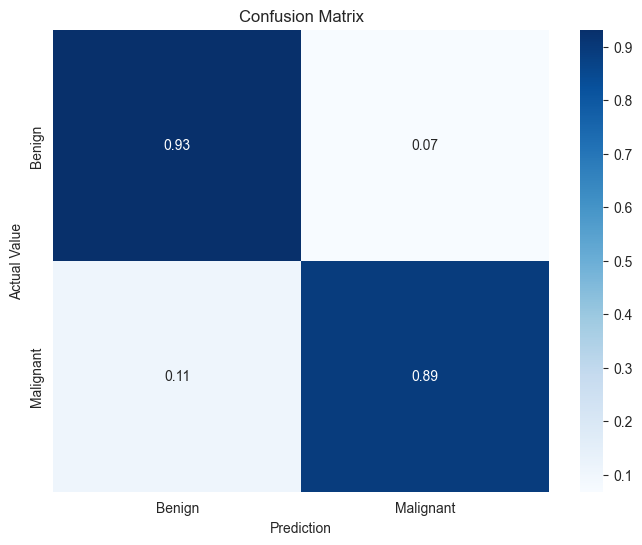

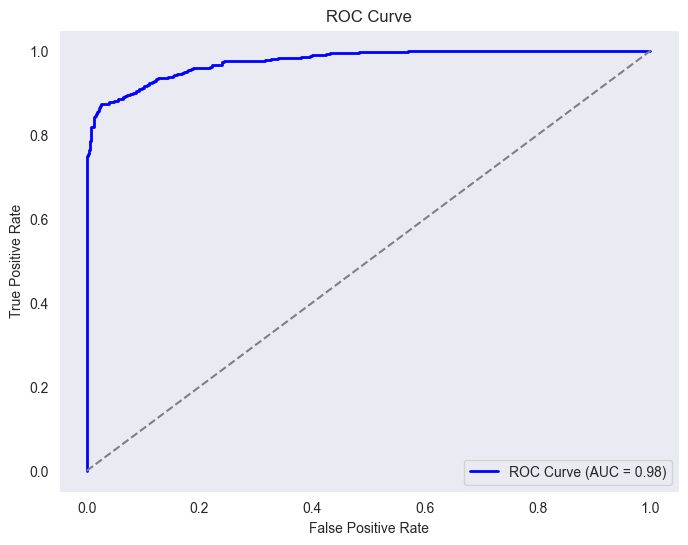

AUC-ROC: 0.98


In [6]:
def evaluate_model(test_folder, model_path=None):
    # Cargar el modelo guardado
    if model_path:
        model = tf.keras.models.load_model(model_path)
    else:
        model = best_model

    # Cargar imágenes de la carpeta de prueba
    X_test, y_test = load_images_from_directory(test_folder)
    X_test = X_test / 255.0  # Normalizar imágenes

    # Realizar predicciones (probabilidades)
    y_pred_prob = model.predict(X_test).flatten()  # Obtener probabilidades para la clase positiva

    # Convertir probabilidades a etiquetas (0 o 1) usando el umbral de 0.5
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calcular y mostrar métricas
    print("\nResultados del modelo:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

    # Crear matriz de confusión normalizada
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

    # Graficar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Actual Value')
    plt.show()

    # Calcular y graficar la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")

# Evaluar el modelo
evaluate_model(test_dir, 'best_melanoma_model_tuned.keras')


### 4. Conclusión

En este proyecto se ha construido un modelo de aprendizaje profundo basado en redes neuronales convolucionales para clasificar imágenes de lunares como benignos o malignos. A través de la búsqueda de hiperparámetros con _keras-tuner_, se ha encontrado una arquitectura óptima que ha sido entrenada y evaluada con un conjunto de datos de testeo.

El modelo ha obtenido un _accuracy_ de 0.91, con un _recall_ y un _f1-score_ alto para ambas clases. La matriz de confusión muestra que el modelo ha logrado clasificar correctamente la mayoría de las imágenes, tanto benignas como malignas. En la curva ROC, se observa un área bajo la curva (AUC) de 0.98, lo que indica un buen rendimiento del modelo en la clasificación binaria.

Se observa que el modelo ha logrado un buen rendimiento en la clasificación de las imágenes, lo que sugiere que podría ser una herramienta útil para apoyar a los dermatólogos en la detección temprana de melanomas. Sin embargo, siempre es importante tener en cuenta que este modelo es una herramienta de apoyo y no reemplaza el juicio clínico de un profesional de la salud.